# A Puzzle with Intervals (CIs vs. PIs)

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from plotnine import *
import scipy.stats as stats

### First let's review the idea of confidence.

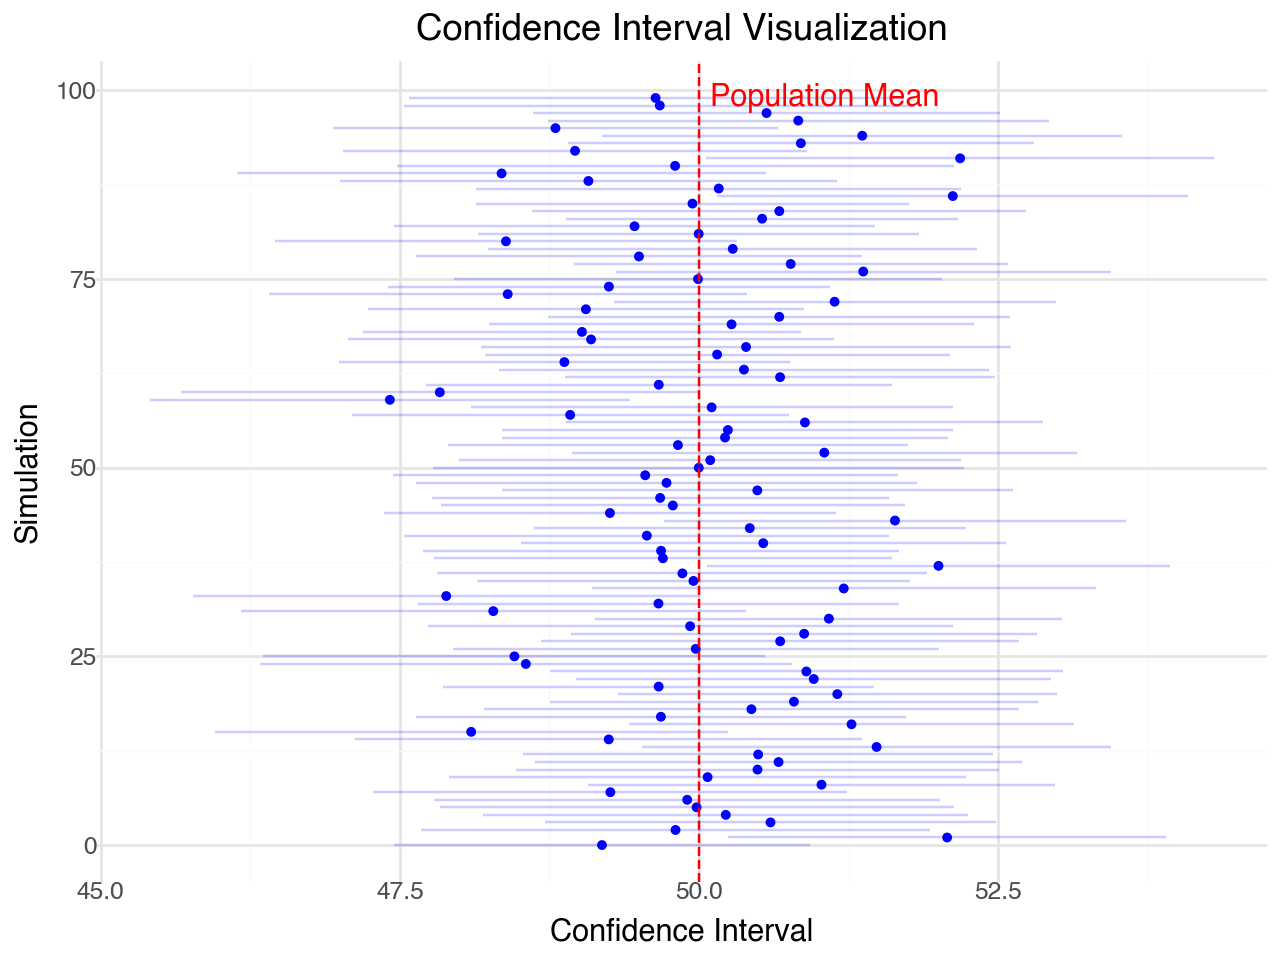

<Figure Size: (640 x 480)>

In [4]:
# Generate sample data
np.random.seed(1234321)
sample_size = 100
population_mean = 50
population_std = 10

# Calculate confidence intervals for multiple simulations
num_simulations = 100
confidence_level = 0.95
intervals = []

for i in range(num_simulations):
    sample = np.random.normal(population_mean, population_std, sample_size)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)  # Use ddof=1 for sample standard deviation
    margin_of_error = stats.t.ppf((1 + confidence_level) / 2, df=sample_size - 1) * sample_std / np.sqrt(sample_size)
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    contains_mean = (lower_bound <= population_mean) and (population_mean <= upper_bound)
    color = 'Success' if contains_mean else 'Miss'
    intervals.append((i, sample_mean, lower_bound, upper_bound, color))


# Convert to DataFrame for plotnine
df_intervals = pd.DataFrame(intervals, columns=['Simulation', 'SampleMean', 'Lower', 'Upper', 'Color'])


p = (ggplot(df_intervals, aes(y='Simulation'))
     + geom_segment(aes(x='Lower', xend='Upper', yend='Simulation'), color='blue', alpha=0.2)
     + geom_point(aes(x='SampleMean'), color='blue', size=1)
     + geom_vline(xintercept=population_mean, color='red', linetype='--')
     + annotate("text", y=num_simulations-1, x=population_mean + 1.05, label='Population Mean', color='red')
     + labs(y='Simulation', x='Confidence Interval', title='Confidence Interval Visualization')
     + theme_minimal())

p

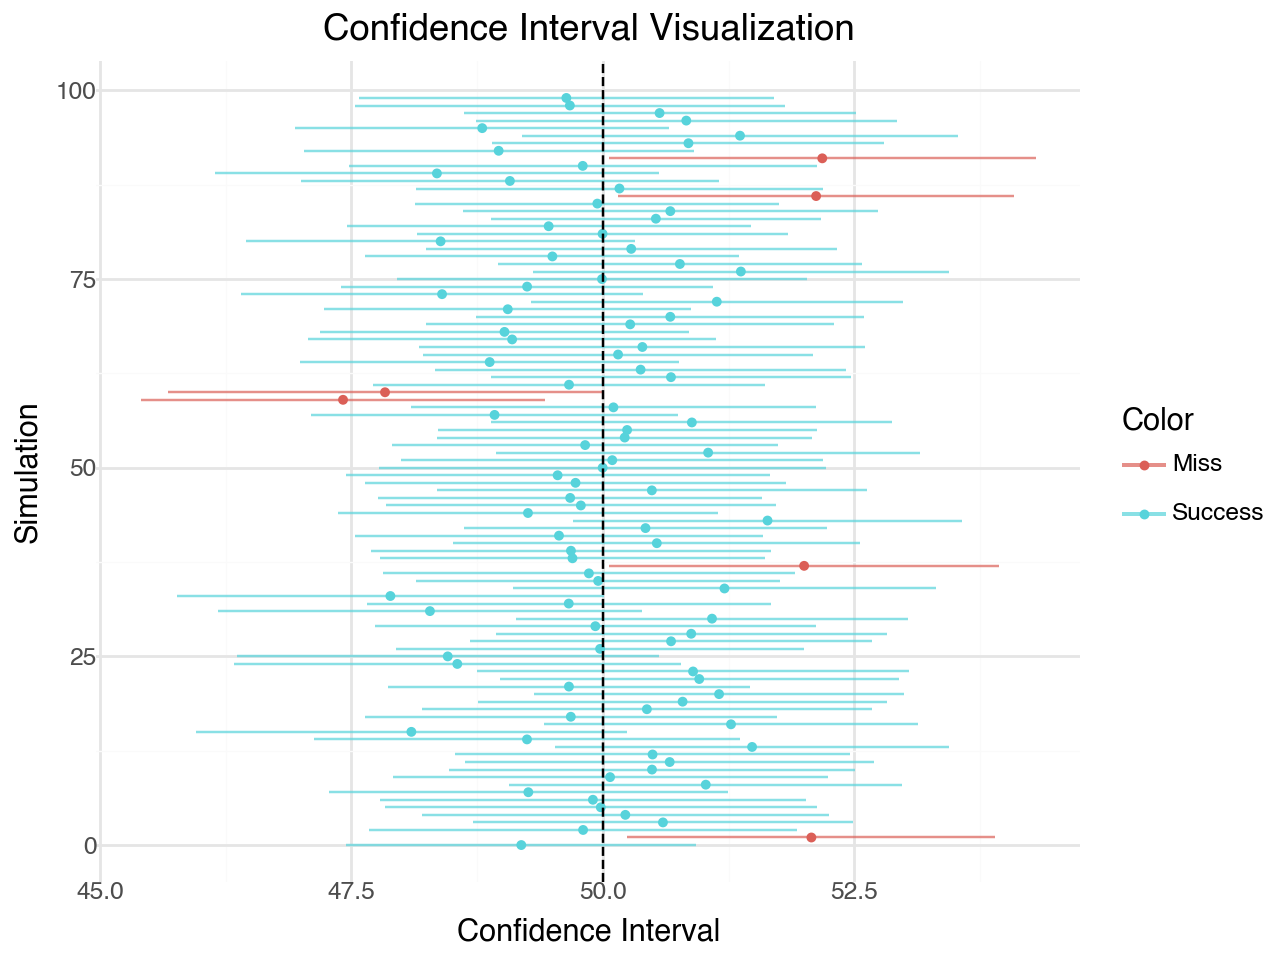

<Figure Size: (640 x 480)>

In [5]:
# Plot the confidence intervals using plotnine
pp = (ggplot(df_intervals, aes(y='Simulation'))
     + geom_segment(aes(x='Lower', xend='Upper', yend='Simulation', color='Color'), alpha=0.7)
     + geom_point(aes(x='SampleMean', color='Color'), size=1)
     + geom_vline(xintercept=population_mean, color='black', linetype='--')
     + labs(y='Simulation', x='Confidence Interval', title='Confidence Interval Visualization')
     + theme_minimal())

pp

### CIs in Simple Linear Regression

So far we've learned about CIs for our LS coefficients $\hat{\beta}_k,~k=0,1,$ and also for the mean of the response at given levels of the predictor $E(Y|X=x)$.

They take the form: 

$$\widehat{\beta}_0 \pm t^*_{n-2}(1-\alpha/2)\cdot  \widehat{\sigma}\sqrt{\frac{1}{n} + \frac{\bar{x}^2}{SSX}}$$

$$\widehat{\beta}_1 \pm t^*_{n-2}(1-\alpha/2) \cdot \widehat{\sigma}\sqrt{\frac{1}{SSX}}$$
and 

$$\widehat{y} (x) \pm t^*_{n-2}(1-\alpha/2) \cdot \widehat{\sigma}\sqrt{\frac{1}{n} + \frac{(x_i - \bar{x})^2}{SSX}}.$$
Also recall that the last term $\widehat{y} (x)$ is an estimate of $g(x) = E(y|X = x)$, the mean of the response at a given $x$ value. 

Notice the general form of each of these intervals is:
$$estimate \pm MoE  $$
$$estimate \pm crit. value \cdot (typical~ prediction~ error)$$
$$estimate \pm crit. value \cdot \widehat{SE}(estimate - target)$$

(MoE = margin of error)

### Exercise:

Using the first two CI expressions listed here, modify the simulation above to visualize the fraction of CIs which cover the true slope and intercept in the simple linear model. If you do a large number of simulations, do you achieve the expected coverage? 

### Now let's explore on a real dataset. 

A criminologist studied the relationship between level of education and crime rate. He collected data from 84 medium-sized US counties. Two variables were measured: X – the percentage of individuals having at least a high-school diploma; and Y – the crime rate (crimes reported per 100, 000 residents) in the previous year. The complete data is in “crimerate.txt”.


In [12]:
# Load the crime rate data
crimerate = pd.read_csv("/Users/cjcarroll/Desktop/repos/regression_f24/data/crimerate.txt", sep='\s+') #uses \s+ to match one or more whitespace characters (spaces, tabs, etc.).

# Number of observations
n = len(crimerate)
crimerate.columns = ['rate', 'pct_diploma']

crimerate.head()

,rate,pct_diploma
0,8487,74
1,8179,82
2,8362,81
3,8220,81
4,6246,87


In [13]:
mod_crime = smf.ols('rate ~ pct_diploma', data=crimerate).fit()

# Summary of the model
print(mod_crime.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     16.83
Date:                Tue, 03 Sep 2024   Prob (F-statistic):           9.57e-05
Time:                        09:45:44   Log-Likelihood:                -770.43
No. Observations:                  84   AIC:                             1545.
Df Residuals:                      82   BIC:                             1550.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.052e+04   3277.643      6.260      

In [14]:
# 1. The fitted value when x = 80
beta_hat = mod_crime.params

def yhat(x):
    return beta_hat[0] + beta_hat[1] * x

In [15]:
# 2. Critical value
alpha = 0.05
crit = stats.t.ppf(1 - alpha/2, df=n-2)

$SE (\hat{\theta}) = \sqrt{Var(\hat{\theta})}$

In [16]:
# 3. Estimated standard error of E(Y|X = x)
sigma2hat = sum(mod_crime.resid**2) / (n - 2)
sigmahat = np.sqrt(sigma2hat)
x_values = crimerate['pct_diploma']
xbar = np.mean(x_values)
SSX = sum((x_values - xbar)**2)

def seyhat(x):
    return sigmahat * np.sqrt(1 + 1/n + (x - xbar)**2 / SSX)

NameError: name 'mod_crime' is not defined

In [17]:
# Standard error at x = 80
seyhat_value = seyhat(x=80)
print(f"Standard error at x = 80: {seyhat_value.round(4)}")


Standard error at x = 80: 263.6425


In [18]:
# 95% CI for the mean crime rate when HS grad rate is 80%
ci = yhat(x=80) + np.array([-1, 1]) * crit * seyhat(x=80)
print(f"95% CI: ", ci)

# Simulate a new county with a HS grad rate of 80% and check if it falls within our interval.
# Technically we dont know the true parameters, so it's hard to simulate this. 
# We just have to use our best guesses for the parameters based on our estimates and pretend they are the ground truth here... 
beta_0 = 20517.6 
beta_1 = -170.5752 
sigma = 2356.292

np.random.seed(123)
x = 80

def ynew(x):
    eps = np.random.normal(0, sigma, 1)
    return beta_0 + beta_1 * x + eps


ynew_value = ynew(x=80)[0]
print(f"My simulated new observation has a rate of {ynew_value.round(4)} when pct_diploma = 80.")

95% CI:  [6347.11594305 7396.05376506]
My simulated new observation has a rate of 4313.5213 when pct_diploma = 80.


/var/folders/xp/wk0n_cc925g6bz7szq91rxhxpvk82n/T/ipykernel_90701/2999861836.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


### Is that value captured in my CI?

In [21]:
captured = (ynew_value > ci[0]) & (ynew_value < ci[1])
print("New value captured in CI:", captured)

New value captured in CI: False


#### Hmm... 
The new value is not in the interval, but that can happen with CIs.  Maybe we were just unlucky-- let's try to simulate 10,000 counties with HS grad rates of 80\% and see if we get the proper coverage of 95\%.

In [32]:
# Simulate N = 10,000 counties' crime rates with HS grad rates of 80%
N = 10000
np.random.seed(123)
eps = np.random.normal(0, sigma, N)
ynew_values = beta_0 + beta_1 * x + eps

captured_values = (ynew_values > ci[0]) & (ynew_values < ci[1])
coverage_rate = np.sum(captured_values) / N
print("Coverage rate:", coverage_rate)

Coverage rate: 0.1794


#### Yikes! We were expecting 95\%....
Not even close... what's going wrong???

## Exercises:

1. Consider the following 2 quantites:\
   a. $(y_{n+1}|x=80) = \beta_0 + \beta_1 (80) + \epsilon_{n+1}$ \ (pred.)
   and \
   b. $g(x = 80) = E(y_{n+1}|x = 80) = \beta_0 + \beta_1 (80)$. (conf)

   What do they represent in the real life context of the problem?  Which is deterministic? Which is random? 

2. These quantities in a. and b. are our targets. The first is our target when we construct a prediction interval, the second is our target for a confidence interval. The point estimator for each is

$$\hat{y}_{(x = 80)} = \hat{\beta}_0 + \hat{\beta}_1 (80)$$

We will now try to understand why a PI is calculated differently than a CI. 

To do this, calculate the standard error of the difference between the point estimator and the target. This is basically like the expected error.

In other words, show mathematically that:\
a. $SE(\hat{y}_{(x = 80)} - (y_{n+1}|x=80)) = \sigma \sqrt{(1 +  \frac{1}{n} + \frac{(x - \bar{x})^2  }{SSX})}$ and\
b. $SE(\hat{y}_{(x = 80)} - g(x = 80)) = \sigma \sqrt{( \frac{1}{n} + \frac{(x - \bar{x})^2  }{SSX})}$

(Hint: pay attention to the error term in part a.)

$SE(\hat{y}_{(x = 80)} - (y_{n+1}|x=80)) = \sigma \sqrt{(1 +  \frac{1}{n} + \frac{(x - \bar{x})^2  }{SSX})}$

$SE(\hat{y}_{(x = 80)} - (y_{n+1}|x=80)) = \sqrt{(Var(\hat{y}_{(x = 80)} - (y_{n+1}|x=80)))}$

$Var(\hat{y}_{(x = 80)} - (y_{n+1}|x=80)) = Var(\hat{y}_{(x = 80)} - (\beta_0 + \beta_1x + \epsilon_{n+1})) = Var(\hat{y}_{(x = 80)}) +  Var((\beta_0 + \beta_1x + \epsilon_{n+1}))$

$Var(\hat{y}_{(x = 80)}) = \sigma^2 (\frac{1}{n} + \frac{(x -\bar{x})^2}{SSX})$



$Var(\epsilon_{n+1}) = \sigma^2$

$Var(\hat{y}_{(x = 80)} - y_{n+1}) = \sigma^2 (1 + \frac{1}{n} + \frac{(x -\bar{x})^2}{SSX})$


3.  For part a. (the prediction interval) adjust the margin of error to account for what you showed in part 2a. Calculate a new interval using the adjusted standard error. 

In [ ]:
def seyhatnew(x):
    return sigmahat * np.sqrt(1 + 1/n + (x - xbar)**2 / SSX)

4. Retry the simulation we did before, but now use the adjusted standard error for the prediction interval. What is the coverage rate for the new interval? 

In [82]:
# Exercise: Adjust the margin of error and calculate a new interval
def seyhatnew(x):
    return sigmahat * np.sqrt(1 + 1/n + (x - xbar)**2 / SSX)

pi = yhat(x=80) + np.array([-1, 1]) * crit * seyhatnew(x=80)
print(pi)

np.random.seed(123)
eps = np.random.normal(0, sigma, N)
ynew_values = beta_0 + beta_1 * x + eps

captured_values = (ynew_values > pi[0]) & (ynew_values < pi[1])
new_coverage_rate = np.sum(captured_values) / N
print("New coverage rate:", new_coverage_rate)

[ 2154.91972694 11588.24998117]
New coverage rate: 0.9567


/var/folders/xp/wk0n_cc925g6bz7szq91rxhxpvk82n/T/ipykernel_90701/2999861836.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
